In [1]:
# Import Packages

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

#SET BOARD SIZE
size_board = 4

In [2]:
##INITIALISE A GAME
env=Chess_Env(size_board)
SS,XS,allowed_aS=env.Initialise_game()
N_actions = len(allowed_aS)#length of allowed actions

In [3]:
##IMPLEMENT EPSILON GREEDY POLICY
def EpsilonGreedy_Policy(Q, epsilon):

    rand_value=np.random.uniform(0,1)

    rand_a=rand_value<epsilon
    
    aS,_=np.where(allowed_a==1)
    if rand_a==True:
        
        a=np.random.choice(aS)

    else:

        maxQ=np.argmax(Q)
        a = aS[maxQ]
            
    return a

In [4]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 

class Model:
    def __init__(self):
        self.layers = []
        self.loss = []   
    def add(self, layer):
        self.layers.append(layer)
    def predict(self, X):
        # Forward pass
        for i, _ in enumerate(self.layers):
            forward = self.layers[i].forward(X)
            X = forward          
        return forward

    def update_w(self, X, Y, learning_rate):
        # Forward pass
        for i, _ in enumerate(self.layers):
            forward = self.layers[i].forward(input_val=X)
            X = forward         
        # Compute loss and first gradient
        mse = MeanSquaredError(forward, Y)
        error = mse.forward()
        gradient = mse.backward()  
        self.loss.append(error)
         
        # Backpropagation
        for i, _ in reversed(list(enumerate(self.layers))):
            if self.layers[i].type != 'Linear':
                gradient = self.layers[i].backward(gradient)
            else:
                gradient, dW, dB = self.layers[i].backward(gradient)
                self.layers[i].optimize(dW, dB, learning_rate)             
        return error


class Layer: #Layer abstract class
    def __init__(self):
        pass   
    def __len__(self):
        pass     
    def __str__(self):
        pass   
    def forward(self):
        pass   
    def backward(self):
        pass  
    def optimize(self):
        pass
        
class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        np.random.seed(90)#set random seeds
        self.weights = np.random.rand(output_dim, input_dim)
        np.random.seed(90)
        self.biases = np.random.rand(output_dim, 1)
        self.type = 'Linear'
    def __str__(self):
        return f"{self.type} Layer"     
    def forward(self, input_val):
        self._prev_acti = input_val.reshape(self.weights.shape[1],1)
        return np.matmul(self.weights, input_val).reshape(self.weights.shape[0],1) + self.biases   
    def backward(self, dA):
        dW = np.dot(dA, self._prev_acti.T)
        dB = dA.mean(axis=1, keepdims=True)        
        delta = np.dot(self.weights.T, dA)        
        return delta, dW, dB    
    def optimize(self, dW, dB, rate):
        self.weights = self.weights - rate * dW
        self.biases = self.biases - rate * dB  
        
class ReLU(Layer):    
    def __init__(self, output_dim):
        self.units = output_dim
        self.type = 'ReLU'
    def __str__(self):
        return f"{self.type} Layer"               
    def forward(self, input_val):
        self._prev_acti = np.maximum(0, input_val)
        return self._prev_acti    
    def backward(self, dJ):
        return dJ * np.heaviside(self._prev_acti, 0)

class Sigmoid(Layer):
    def __init__(self, output_dim):
        self.units = output_dim
        self.type = 'Sigmoid'
    def __str__(self):
        return f"{self.type} Layer"                
    def forward(self, input_val):
        self._prev_acti = 1 / (1 + np.exp(-input_val))
        return self._prev_acti    
    def backward(self, dJ):
        sig = self._prev_acti
        return dJ * sig * (1 - sig)
    
class MeanSquaredError(Layer):
    def __init__(self, predicted, real):
        self.predicted = predicted
        self.real = real
        self.type = 'Mean Squared Error'
    def forward(self):
        return np.power(self.predicted - self.real, 2).mean()
    def backward(self):
        return 2 * (self.predicted - self.real)/self.predicted.size

In [5]:
## INITALISE YOUR NEURAL NETWORK...
 ## NUMBER OF HIDDEN NODES
N_h=200
# Create model
model = Model() 
# Add layers
model.add(Linear(np.shape(XS)[0], N_h))
model.add(ReLU(N_h))
model.add(Linear(N_h,32))
model.add(ReLU(32))

In [6]:
# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


N_episodes=100000 # THE NUMBER OF GAMES TO BE PLAYED 

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_sarsa = np.zeros([N_episodes, 1])
N_moves_save_sarsa = np.zeros([N_episodes, 1])
R_save_qlearning=np.zeros([N_episodes, 1])
N_moves_save_qlearning=np.zeros([N_episodes, 1])

In [7]:
# EXPONENTIAL MOVING AVERAGE: B = [0,1]
def EMA(Y,B):
    y = 0
    EMAY = []
    for n in Y:
        y = B * y + (1 - B) * n
        EMAY.append(y.copy())
    return EMAY

In [8]:
#TRAINING STRUCTURE
for n in range(N_episodes):
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        Qvaluesall = model.predict(X.reshape(58,1))#Get Q-values
        Qvaluesactions = Qvaluesall[np.where(allowed_a==1)[0]]#Select Q-values of allowed actions
        a_agent=EpsilonGreedy_Policy(Qvaluesactions, epsilon_f)#Choose an action by policy
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)#Go one step
        
        if Done:
            
            R_save_sarsa[n]=np.copy(R) #Save the reward
            N_moves_save_sarsa[n]=np.copy(i)#Save the number of moves
            Qvaluesall[a_agent] = R#Update Q-values
            model.update_w(X,Qvaluesall,eta)#Update the weights in DNN
            break
            
        # IF THE EPISODE IS NOT OVER...    
        else:
            
            # NEXT STATE AND CO. BECOME ACTUAL STATE... 
            Qvaluesall_next = model.predict(X_next.reshape(58,1)) #Get Q-values of the next states
            Qvaluesactions_next = Qvaluesall_next[np.where(allowed_a==1)[0]]#Select Q-values of allowed actions
            a_agent_next = EpsilonGreedy_Policy(Qvaluesactions_next, epsilon_f)#Choose an action which has the largest Q-value. 
            Qvaluesall[a_agent] = R + gamma*Qvaluesall_next[a_agent_next]#Update Q-values
            model.update_w(X,Qvaluesall,eta)#update the weights in DNN

            S=np.copy(S_next)#Update the states
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)# Update the allowed actions

        # UPDATE THE COUNTER
        i=i+1
    #call back
    if n%500 ==0:
        print("Have Finished "+ str(n)+" Epoachs")
        


Have Finished 0 Epoachs
Have Finished 500 Epoachs
Have Finished 1000 Epoachs
Have Finished 1500 Epoachs
Have Finished 2000 Epoachs
Have Finished 2500 Epoachs
Have Finished 3000 Epoachs
Have Finished 3500 Epoachs
Have Finished 4000 Epoachs
Have Finished 4500 Epoachs
Have Finished 5000 Epoachs
Have Finished 5500 Epoachs
Have Finished 6000 Epoachs
Have Finished 6500 Epoachs
Have Finished 7000 Epoachs
Have Finished 7500 Epoachs
Have Finished 8000 Epoachs
Have Finished 8500 Epoachs
Have Finished 9000 Epoachs
Have Finished 9500 Epoachs
Have Finished 10000 Epoachs
Have Finished 10500 Epoachs
Have Finished 11000 Epoachs
Have Finished 11500 Epoachs
Have Finished 12000 Epoachs
Have Finished 12500 Epoachs
Have Finished 13000 Epoachs
Have Finished 13500 Epoachs
Have Finished 14000 Epoachs
Have Finished 14500 Epoachs
Have Finished 15000 Epoachs
Have Finished 15500 Epoachs
Have Finished 16000 Epoachs
Have Finished 16500 Epoachs
Have Finished 17000 Epoachs
Have Finished 17500 Epoachs
Have Finished 18

In [9]:
## INITALISE YOUR NEURAL NETWORK...
 ## NUMBER OF HIDDEN NODES
N_h=200
# Create model
model_q = Model() 
# Add layers
model_q.add(Linear(np.shape(XS)[0], N_h))
model_q.add(ReLU(N_h))
model_q.add(Linear(N_h,32))
model_q.add(ReLU(32))

In [10]:
#TRAINING STRUCTURE-q learning
for n in range(N_episodes):
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:  
        

        Qvaluesall = model_q.predict(X)    #Get Q-values
        Qvaluesactions = Qvaluesall[np.where(allowed_a==1)[0]]#Select Q-values of allowed actions
        a_agent=EpsilonGreedy_Policy(Qvaluesactions, epsilon_f)#Choose an action by policy
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)#Go one step
        if Done:
            
            R_save_qlearning[n]=np.copy(R)  #Save the reward
            N_moves_save_qlearning[n]=np.copy(i)#Save the number of moves
            Qvaluesall[a_agent] = R#Update Q-values
            model_q.update_w(X,Qvaluesall,eta)#Update the weights in DNN
            break
            
        # IF THE EPISODE IS NOT OVER...    
        else:
            
            Qvaluesall_next = model_q.predict(X_next)#Get Q-values of the next states
            Qvaluesactions_next = Qvaluesall_next[np.where(allowed_a==1)[0]]#Select Q-values of allowed actions
            a_agent_next = EpsilonGreedy_Policy(Qvaluesactions_next, 0)   #Choose an action which has the largest Q-value.              
            Qvaluesall[a_agent] = R + gamma*Qvaluesall_next[a_agent_next] #Update Q-values
            model_q.update_w(X,Qvaluesall,eta)        
            S=np.copy(S_next)
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)

        # UPDATE THE COUNTER
        i=i+1                               
        
    #call back
    if n%500 ==0:
        print("Have Finished "+ str(int(n))+" Epoachs")

Have Finished 0 Epoachs
Have Finished 500 Epoachs
Have Finished 1000 Epoachs
Have Finished 1500 Epoachs
Have Finished 2000 Epoachs
Have Finished 2500 Epoachs
Have Finished 3000 Epoachs
Have Finished 3500 Epoachs
Have Finished 4000 Epoachs
Have Finished 4500 Epoachs
Have Finished 5000 Epoachs
Have Finished 5500 Epoachs
Have Finished 6000 Epoachs
Have Finished 6500 Epoachs
Have Finished 7000 Epoachs
Have Finished 7500 Epoachs
Have Finished 8000 Epoachs
Have Finished 8500 Epoachs
Have Finished 9000 Epoachs
Have Finished 9500 Epoachs
Have Finished 10000 Epoachs
Have Finished 10500 Epoachs
Have Finished 11000 Epoachs
Have Finished 11500 Epoachs
Have Finished 12000 Epoachs
Have Finished 12500 Epoachs
Have Finished 13000 Epoachs
Have Finished 13500 Epoachs
Have Finished 14000 Epoachs
Have Finished 14500 Epoachs
Have Finished 15000 Epoachs
Have Finished 15500 Epoachs
Have Finished 16000 Epoachs
Have Finished 16500 Epoachs
Have Finished 17000 Epoachs
Have Finished 17500 Epoachs
Have Finished 18

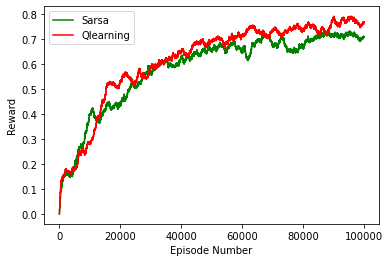

In [27]:
## PLOT THE TOTAL REWARD PER EPISODE AS TRAINING PROGRESSES
plt.figure()
plt.plot(EMA(R_save_sarsa[0:100000],0.999), color='green', label="Sarsa")
plt.plot(EMA(R_save_qlearning[0:100000],0.999), color='red', label="Qlearning")
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.legend()
plt.show()

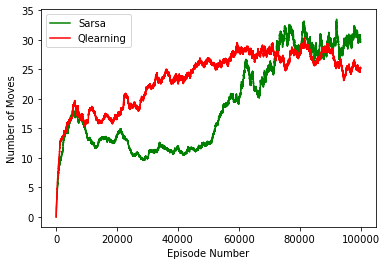

In [28]:
## PLOT THE NUMBER OF MOVES AS TRAINING PROGRESSES

plt.figure()
plt.plot(EMA(N_moves_save_sarsa,0.999), color='green', label="Sarsa")
plt.plot(EMA(N_moves_save_qlearning,0.999), color='red', label="Qlearning")
plt.xlabel('Episode Number')
plt.ylabel('Number of Moves')
plt.legend()
plt.show()